### find pure domains (mostly path/benign vars)

In [1]:
import pandas

In [32]:
def calc_path_frac(rows):
    pfam = list(rows['pfam'].values)[0]
    pathogenic = len(rows[ (rows.clin_class=='PATHOGENIC') | (rows.clin_class=='LIKLEY_PATHOGENIC')])
    benign = len(rows[ (rows.clin_class=='LIKELY_BENIGN') | (rows.clin_class=='BENIGN')])
    frac = -1
    if pathogenic+benign:
        frac = pathogenic/(pathogenic+benign)
    return pandas.Series([frac, len(rows)], index=['path_frac', 'size'])

dat_file = '../data/interim/EPIv6.eff.dbnsfp.anno.hHack.dat.xls'
df_pre = pandas.read_csv(dat_file, sep='\t')
df = (df_pre['pfam'].str.split(',', expand=True)
     .stack()
     .reset_index(level=0)
     .set_index('level_0')
     .rename(columns={0:'pfam'})
     .join(df_pre.drop('pfam',1), how='left')
     )
dd = df.groupby('pfam').apply(calc_path_frac)

In [35]:
ff = dd.reset_index()
# mostly path
len(ff[(ff.size>4) & (ff.path_frac==1)])

157

In [36]:
# mostly benign
len(ff[(ff.size>4) & (ff.path_frac==0)])

111

In [44]:
# mk domain features
def match(row, domain_info):
    ls = []
    for pfam in row['pfam'].split(','):
        if domain_info[pfam][2] == 0:
            ls.append(domain_info[pfam])
    if len(ls) == 0:
        for pfam in row['pfam'].split(','):
            return domain_info[pfam]
        
    if len(ls) == 1:
        return ls[0]
    else:
        return ls[0]
    
ff.loc[:, 'path_na'] = ff.apply(lambda row: 1 if row['path_frac']==-1 else 0, axis=1)
domain_info = {pfam:[path_frac, size, path_na]
               for pfam, path_frac, size, path_na
               in ff.values}

df_pre.loc[:, 'path_frac'] = df_pre.apply(lambda row: match(row, domain_info)[0], axis=1)
df_pre.loc[:, 'size'] = df_pre.apply(lambda row: match(row, domain_info)[1], axis=1)
df_pre.loc[:, 'path_na'] = df_pre.apply(lambda row: match(row, domain_info)[2], axis=1)

In [45]:
## predict
import pandas, pydot, pydotplus, graphviz
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics, tree, svm
from sklearn.neural_network import MLPClassifier
from sklearn.externals.six import StringIO
from IPython.display import HTML
%matplotlib inline

In [50]:
df_x = df_pre[ (df_pre.clin_class != 'VUS') & (df_pre.mpc>0) & (df_pre.pfam != 'none')]
df_x.loc[:, 'y'] = df_x.apply(lambda row: 1 if row['clin_class'] in ('PATHOGENIC', 'LIKLEY_PATHOGENIC')
                            else 0, axis=1)
df_x.head()

/opt/conda/lib/python3.4/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.4/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,chrom,pos,ref,alt,clin_class,pfam,af_1kg_all,eff,pos_fam,neg_fam,gene,mpc,exac_af,exac_cov_frac,kaviar_af,c.,path_frac,size,path_na,y
4,1,40542572,T,C,PATHOGENIC,Palm_thioest:3,0.000000,missense_variant,2,8544,PPT1,0.6458,0.000008,1.0000,0.000006,NM_000310.3:c.740A>G,1.0,3.0,0,1
12,1,40555089,G,C,PATHOGENIC,"Palm_thioest:6,Palm_thioest:7",0.000000,missense_variant,1,8544,PPT1,0.6009,0.000041,1.0000,0.000045,NM_000310.3:c.529C>G,1.0,4.0,0,1
16,1,40557070,T,A,PATHOGENIC,Palm_thioest:9,0.000599,missense_variant,2,8543,PPT1,0.5571,0.000683,0.9957,0.000540,NM_000310.3:c.364A>T,1.0,3.0,0,1
18,1,40557754,A,C,PATHOGENIC,Palm_thioest:10,0.000000,missense_variant,1,8544,PPT1,0.7771,0.000008,0.9998,0.000006,NM_000310.3:c.325T>G,0.5,3.0,0,1
19,1,40557769,T,C,LIKELY_BENIGN,Palm_thioest:10,0.000000,missense_variant,2,8543,PPT1,0.2277,0.000025,1.0000,0.000019,NM_000310.3:c.310A>G,0.5,3.0,0,0


In [47]:
tree_clf = tree.DecisionTreeClassifier(max_depth=5)

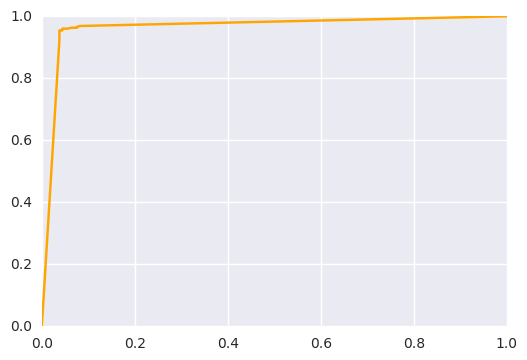

In [52]:
# decision tree
all_preds = []
all_truth = []
cols = ['mpc', 'size', 'path_na', 'path_frac']
genes = set(df_x['gene'].values)
for gene in genes:
    df_train = df_x[df_x.gene!=gene]
    df_test = df_x[df_x.gene==gene]
    X, y = df_train[cols], df_train['y']
    tree_clf.fit(X, y)
    dot_data = StringIO()
    tree.export_graphviz(tree_clf, feature_names=cols, out_file=dot_data)
    graph = pydotplus.graph_from_dot_data( dot_data.getvalue() )
    graph.write_pdf('mtr_tree.%s.pdf' % (gene,))
    X_test, y_test = df_test[cols], df_test['y']
    preds = tree_clf.predict_proba(X_test)
    preds_simple = tree_clf.predict(X_test)
    tot, good = 0,0
    for pred, pred_s, truth in zip(preds, preds_simple, y_test):
        all_preds.append(pred[1])
        all_truth.append(truth)
        tot += 1
        if pred_s==truth:
            good += 1
    #print(gene, tot, good, good/tot)
fpr_tree, tpr_tree, _ = metrics.roc_curve(all_truth, all_preds, pos_label=1)
plt.plot(fpr_tree, tpr_tree, label='tree', color='orange')

In [53]:
HTML('<iframe src=./mtr_tree.CDKL5.pdf width=1000 height=500></iframe>')